# Forex Factory
---
Scrapper & Data Cleansing/Modelling

In [3]:
import logging
import sys
import datetime
import requests
import bs4
import numpy as np
import pandas as pd

### To do
test etoro api

In [15]:
def logger_settings():

    # Setting Logger
    logger = logging.getLogger(__name__)

    # Setting Handlers
    c_handler = logging.StreamHandler(sys.stdout)
    c_handler.setLevel(logging.INFO)

    f_handler = logging.FileHandler(f'{__name__}.log')
    f_handler.setLevel(logging.INFO)

    # Formatting log messages
    c_format = logging.Formatter('%(asctime)s :: %(name)s :: %(levelname)-8s :: %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
    c_handler.setFormatter(c_format)

    f_format = logging.Formatter('%(asctime)s :: %(name)s :: %(levelname)-8s :: %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
    f_handler.setFormatter(f_format)

    # Assigning handlers to logger object
    logger.addHandler(c_handler)
    logger.addHandler(f_handler)

    return logger

In [25]:
def fetch_html(url, headers, logger=logger):
    '''
    Sends request message to url and returns raw html
    '''
    resp = requests.get(url, headers=headers)
    
    if resp.status_code == 200:
        logger.info(f'URL: {url}, status code: 200')
    else:
        logger.error(f'URL: {url}, status code: {resp.status_code}')
        
    return resp

def parse_forexfactory_page(response, logger=logger):
    '''
    Parses raw html from ForexFactory.com/calendar. Returns bs4 object containing calendar table information.
    '''
    try:
        soup = bs4.BeautifulSoup(response.content)
        table = soup.find('table', class_='calendar__table')
        rows_raw = table.find_all('tr')
        # Removing unnecessary rows.
        rows = [row for row in rows_raw if not isinstance(row, bs4.element.NavigableString) and row['class'][0] == 'calendar__row']
        
        logger.info(f'Forex Factory calendar page parsed successfully')
        
    except Exception as initial_parsing_error:
        logger.error('Error parsing Forex Factory calendar table', exc_info=True)
        
    return rows

In [ ]:
def parse_forexfactory_calendar(raw_calendar, logger=logger):
    '''
    Parses previously fetched data and creates pandas dataframe
    '''
    
    element_errors = []
    table_data = []

    # Iterate over each row element getting the text. Appends to a list at the end of every loop.
    for indx, row in enumerate(raw_calendar):#self._rows):
        
        # Date
        try:
            date = row.find('td' , class_='calendar__cell calendar__date').text.strip()
        except AttributeError:
            date = None
        except Exception as element_error:
            element_errors.append([indx, 'date'])

        # Time
        try:
            time = row.find('td' , class_='calendar__cell calendar__time').text.strip()
        except AttributeError:
            time = None
        except Exception as element_error:
            element_errors.append([indx, 'time'])

        # Currency
        try:
            currency = row.find('td' , class_='calendar__cell calendar__currency').text.strip()
        except AttributeError:
            currency = None
        except Exception as element_error:
            element_errors.append([indx, 'currency'])

        # Impact
        try:
            impact_color = row.find('td' , class_='calendar__cell calendar__impact').find('span')['class'][1].split('-')[-1]
        if impact_color == 'ora':
            impact = 'Medium'
        elif impact_color == 'yel':
            impact = 'Low'
        elif impact_color == 'red':
            impact = 'High'
        elif impact_color == 'gra':
            impact = 'Non-Economic'
        except AttributeError:
            impact = None
        except Exception as element_error:
            element_errors.append([indx, 'impact'])

      # Event
      try:
        event = row.find('span' , class_='calendar__event-title').text.strip()
      except AttributeError:
        event = None
      except Exception as element_error:
        element_errors.append([indx, 'event'])

      # Actual Value
      try:
        actual_val = row.find('td' , class_='calendar__cell calendar__actual').text.strip()
      except AttributeError:
        actual_val = None
      except Exception as element_error:
        element_errors.append([indx, 'actual_val'])

      # Actual Status
      try:
        actual_status = row.find('td' , class_='calendar__cell calendar__actual').span['class']
        if len(actual_status) > 0:
          actual_status = actual_status[0]
        else:
          actual_status = 'same'
      except AttributeError:
        actual_status = None
      except TypeError:
        actual_status = None
      except Exception as element_error:
        element_errors.append([indx, 'actual_st'])

      # Forecast
      try:
        forecast = row.find('td' , class_='calendar__cell calendar__forecast').text.strip()
      except AttributeError:
        forecast = None
      except Exception as element_error:
        element_errors.append([indx, 'forecast'])

      # Previous
      try:
        previous = row.find('td' , class_='calendar__cell calendar__previous').text.strip()
      except AttributeError:
        previous = None
      except Exception as element_error:
        element_errors.append([indx, 'previous'])

      # Appending new row to list of rows
      table_data.append([date, time, currency, impact, event, actual_val, actual_status, forecast, previous])

    # Checking whether the number of rows in the html is the same in the table.
    try:
      assert len(raw_calendar) == len(table_data)
      logger.info(f'New entries: {len(table_data)-1}')
    except AssertionError as parsing_error:
      logger.error(f'Parsing Error: Parsed data has {len(raw_calendar)-1} rows, table has {len(table_data)-1}')

    # Checking all elements were parsed correctly.
    try:
      assert len(element_errors) == 0
      logger.info(f'Forex Factory calendar page parsed successfully')
    except AssertionError as data_mismatch:
      for err in element_errors:
        logger.error(f'Data Mismatch: {element_errors[0]}, {element_errors[1]}')

In [26]:
def main():
    # Setting logger object
    logger = logger_settings()
    
    # Setting main variables
    logger.info('Initiating... Forex Factory Calendar')
    url = 'https://www.forexfactory.com/calendar'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36'}
    
    # Forex Factory
    response = fetch_html(url, headers, logger=logger)
    raw_calendar = parse_forexfactory_page(response, logger=logger)
    
    return raw_calendar


if __name__ == "__main__":
    data = main()

In [3]:
# Crawler Class

class Crawler(object):

  def __init__(self, url, logger):
    """
    Downloads data from ForexFactory.com
    Parameters:
    - url: String. ForexFactory.com url to be parsed.
    - logger: Log instance from logging module.
    """
    self.url = url
    self.logger = logger

    # Hidden attributes
    self._rows = None
    self._table_data = []
    self._element_errors = []


  def retrieve_raw(self):
    """
    Retrieves raw html from ForexFactory.com. Returns bs4 object containing all table rows.
    """
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36'}

    resp = requests.get(self.url, headers=headers)

    # Checking the connection was successful
    if resp.status_code == 200:
      self.logger.info(f'URL: {self.url}, status code: 200')
    else:
      self.logger.error(f'URL: {self.url}, status code: {resp.status_code}')

    # Checking whether the page has the right information
    try:
      soup = bs4.BeautifulSoup(resp.text)
      table = soup.find('table', class_='calendar__table')
      rows_raw = table.find_all('tr')
      # Removing unnecessary rows.
      self._rows = [row for row in rows_raw if not isinstance(row, bs4.element.NavigableString) and row['class'][0] == 'calendar__row']
    except Exception as initial_parsing_error:
      self.logger.error('Exception occurred', exc_info=True)

  def parse_raw(self):
    '''
    Parses previously fetched data and creates pandas dataframe
    '''

    # Iterate over each row element getting the text. Appends to a list at the end of every loop.
    for indx, row in enumerate(self._rows):
      #if not isinstance(row, bs4.element.NavigableString) and row['class'][0] == 'calendar__row':

      # Date
      try:
        date = row.find('td' , class_='calendar__cell calendar__date').text.strip()
      except AttributeError:
        date = None
      except Exception as element_error:
        self._element_errors.append([indx, 'date'])

      # Time
      try:
        time = row.find('td' , class_='calendar__cell calendar__time').text.strip()
      except AttributeError:
        time = None
      except Exception as element_error:
        self._element_errors.append([indx, 'time'])

      # Currency
      try:
        currency = row.find('td' , class_='calendar__cell calendar__currency').text.strip()
      except AttributeError:
        currency = None
      except Exception as element_error:
        self._element_errors.append([indx, 'currency'])

      # Impact
      try:
        impact_color = row.find('td' , class_='calendar__cell calendar__impact').find('span')['class'][1].split('-')[-1]
        if impact_color == 'ora':
          impact = 'Medium'
        elif impact_color == 'yel':
          impact = 'Low'
        elif impact_color == 'red':
          impact = 'High'
        elif impact_color == 'gra':
          impact = 'Non-Economic'
      except AttributeError:
        impact = None
      except Exception as element_error:
        self._element_errors.append([indx, 'impact'])

      # Event
      try:
        event = row.find('span' , class_='calendar__event-title').text.strip()
      except AttributeError:
        event = None
      except Exception as element_error:
        self._element_errors.append([indx, 'event'])

      # Actual Value
      try:
        actual_val = row.find('td' , class_='calendar__cell calendar__actual').text.strip()
      except AttributeError:
        actual_val = None
      except Exception as element_error:
        self._element_errors.append([indx, 'actual_val'])

      # Actual Status
      try:
        actual_status = row.find('td' , class_='calendar__cell calendar__actual').span['class']
        if len(actual_status) > 0:
          actual_status = actual_status[0]
        else:
          actual_status = 'same'
      except AttributeError:
        actual_status = None
      except TypeError:
        actual_status = None
      except Exception as element_error:
        self._element_errors.append([indx, 'actual_st'])

      # Forecast
      try:
        forecast = row.find('td' , class_='calendar__cell calendar__forecast').text.strip()
      except AttributeError:
        forecast = None
      except Exception as element_error:
        self._element_errors.append([indx, 'forecast'])

      # Previous
      try:
        previous = row.find('td' , class_='calendar__cell calendar__previous').text.strip()
      except AttributeError:
        previous = None
      except Exception as element_error:
        self._element_errors.append([indx, 'previous'])

      # Appending new row to list of rows
      self._table_data.append([date, time, currency, impact, event, actual_val, actual_status, forecast, previous])

    # Checking whether the number of rows in the html is the same in the table.
    try:
      assert len(self._rows) == len(self._table_data)
      self.logger.info(f'New entries: {len(self._table_data)-1}')
    except AssertionError as parsing_error:
      self.logger.error(f'Parsing Error: Parsed data has {len(self._rows)-1} rows, table has {len(self._table_data)-1}')

    # Checking all elements were parsed correctly.
    try:
      assert len(self._element_errors) == 0
      self.logger.info(f'No errors while parsing rows/elements')
    except AssertionError as data_mismatch:
      for err in self._element_errors:
        self.logger.error(f'Data Mismatch: {self._element_errors[0]}, {self._element_errors[1]}')


In [15]:
url = 'https://www.forexfactory.com/calendar?day=today'
url = 'https://www.forexfactory.com/calendar?month=last'

scraper = Crawler(url, logger)
scraper.retrieve_raw()
scraper.parse_raw()


In [16]:
table_headers = ['Date', 'Time', 'Currency', 'Impact', 'Event', 'Actual', 'ActualStatus', 'Forecast', 'Previous']
table_data = scraper._table_data
df = pd.DataFrame(data=table_data, columns=table_headers)
df

,Date,Time,Currency,Impact,Event,Actual,ActualStatus,Forecast,Previous
0,None,None,None,None,None,None,None,None,None
1,Sat Jul 1,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None
3,Sun Jul 2,6:45pm,NZD,Low,Building Consents m/m,-2.2%,same,,-2.6%
4,,7:50pm,JPY,Low,Tankan Manufacturing Index,5,better,3,1
...,...,...,...,...,...,...,...,...,...
394,,7:30pm,JPY,Low,Unemployment Rate,2.5%,better,2.6%,2.6%
395,,8:30pm,JPY,Low,Final Manufacturing PMI,49.6,same,49.4,49.4
396,,9:30pm,AUD,Low,Building Approvals m/m,-7.7%,same,-7.9%,20.6%
397,,9:45pm,CNY,Medium,Caixin Manufacturing PMI,49.2,worse,50.1,50.5


In [17]:
df.to_csv('forex_factory_202307.csv', index=False)

ls: cannot access 'cd': No such file or directory
..:
bin@                        etc/     media/                    root/  tools/
boot/                       home/    mnt/                      run/   usr/
content/                    lib@     NGC-DL-CONTAINER-LICENSE  sbin@  var/
cuda-keyring_1.0-1_all.deb  lib32@   opt/                      srv/
datalab/                    lib64@   proc/                     sys/
dev/                        libx32@  python-apt/               tmp/


In [6]:
# DataFrame Class

class Calendar_Table(obj):




SyntaxError: ignored

In [ ]:
datetime.datetime.now(datetime.timezone.utc).strftime("%Y%m%dT%H:%M:%SZ")

'20230825T12:27:17Z'

In [ ]:
url = 'https://www.forexfactory.com/calendar?day=aug20.2023'
#url = 'https://www.forexfactory.com/calendar?day=today'
#url = 'https://www.forexfactory.com/calendar?week=last'
#url = 'https://www.forexfactory.com/calendar?week=next'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36'}

r = requests.get(url, headers=headers)
print(r)

# Time is US/Canada Eastern Time

<Response [200]>


In [ ]:
soup = bs4.BeautifulSoup(r.text)
table = soup.find('table', class_='calendar__table')
rows_raw = table.find_all('tr')
rows = [row for row in rows_raw if not isinstance(row, bs4.element.NavigableString) and row['class'][0] == 'calendar__row']

In [ ]:
data = []

for row in rows:
  #if not isinstance(row, bs4.element.NavigableString) and row['class'][0] == 'calendar__row':

    # Date
    try:
      date = row.find('td' , class_='calendar__cell calendar__date').text.strip()
    except AttributeError:
      date = ''

    # Time
    try:
      time = row.find('td' , class_='calendar__cell calendar__time').text.strip()
    except AttributeError:
      time = ''

    # Currency
    try:
      currency = row.find('td' , class_='calendar__cell calendar__currency').text.strip()
    except AttributeError:
      currency = ''

    # Impact
    try:
      impact_color = row.find('td' , class_='calendar__cell calendar__impact').find('span')['class'][1].split('-')[-1]
      if impact_color == 'ora':
        impact = 'Medium'
      elif impact_color == 'yel':
        impact = 'Low'
      elif impact_color == 'red':
        impact = 'High'
      elif impact_color == 'gra':
        impact = 'Non-Economic'
    except AttributeError:
      impact = ''

    # Event
    try:
      event = row.find('span' , class_='calendar__event-title').text.strip()
    except AttributeError:
      event = ''

    # Actual Value
    try:
      actual_val = row.find('td' , class_='calendar__cell calendar__actual').text.strip()
    except AttributeError:
      actual_val = ''

    # Actual Status
    try:
      actual_status = row.find('td' , class_='calendar__cell calendar__actual').span['class']
      if len(actual_status) > 0:
        actual_status = actual_status[0]
      else:
        actual_status = 'same'
    except AttributeError:
      actual_status = ''
    except TypeError:
      actual_status = ''

    # Forecast
    try:
      forecast = row.find('td' , class_='calendar__cell calendar__forecast').text.strip()
    except AttributeError:
      forecast = ''

    # Previous
    try:
      previous = row.find('td' , class_='calendar__cell calendar__previous').text.strip()
    except AttributeError:
      previous = ''

    data.append([date, time, currency, impact, event, actual_val, actual_status, forecast, previous])

df = pd.DataFrame(data=data)
df

,0,1,2,3,4,5,6,7,8
0,,,,,,,,,
1,Sun Aug 20,6:45pm,NZD,Low,Trade Balance,-1107M,worse,-50M,-111M
2,,7:01pm,GBP,Low,Rightmove HPI m/m,-1.9%,same,,-0.2%
3,,9:15pm,CNY,High,1-y Loan Prime Rate,3.45%,better,3.40%,3.55%
4,,,CNY,Medium,5-y Loan Prime Rate,4.20%,better,4.05%,4.20%
5,,11:00pm,NZD,Low,Credit Card Spending y/y,3.6%,same,,5.1%


In [ ]:
len(rows)

6

# Yahoo Finance
## 10 years Treasury Bond Yield

In [ ]:
url = 'https://query1.finance.yahoo.com/v8/finance/chart/%5ETNX?region=US&lang=en-US&includePrePost=false&interval=1mo&useYfid=true&range=1d&corsDomain=finance.yahoo.com&.tsrc=finance'
url = 'https://www.marketwatch.com/investing/bond/tmubmusd10y/downloaddatapartial?startdate=07/23/2023%2000:00:00&enddate=08/22/2023%2023:59:59&daterange=d30&frequency=p1d&csvdownload=true&downloadpartial=false&newdates=false&countrycode=bx'
url = 'https://query1.finance.yahoo.com/v7/finance/download/%5ETNX?period1=1661208486&period2=1692744486&interval=1d&events=history&includeAdjustedClose=true'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36'}

r = requests.get(url, headers=headers)
print(r)

<Response [200]>


In [ ]:
rows = r.text.split('\n')
data = [row.split(',') for row in rows]
df = pd.DataFrame(data=data[1:], columns=data[0])
df = df.applymap(lambda x: None if x.lower() == 'null' else x)
df[df.columns[0]] = pd.to_datetime(df[df.columns[0]], format='%Y-%m-%d') # Changing Date column without calling it using its name
df[df.columns[1:]] = df[df.columns[1:]].applymap(pd.to_numeric) # Converting numbers into floats
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-08-22,2.981,3.041,2.965,3.037,3.037,0.0
1,2022-08-23,3.033,3.078,2.983,3.054,3.054,0.0
2,2022-08-24,3.048,3.126,3.048,3.106,3.106,0.0
3,2022-08-25,3.108,3.128,3.020,3.026,3.026,0.0
4,2022-08-26,3.071,3.087,3.008,3.035,3.035,0.0
...,...,...,...,...,...,...,...
299,2023-08-17,4.278,4.328,4.272,4.308,4.308,0.0
300,2023-08-18,4.243,4.280,4.223,4.251,4.251,0.0
301,2023-08-20,NaN,NaN,NaN,NaN,NaN,NaN
302,2023-08-21,4.294,4.354,4.288,4.342,4.342,0.0


<Axes: xlabel='Date'>

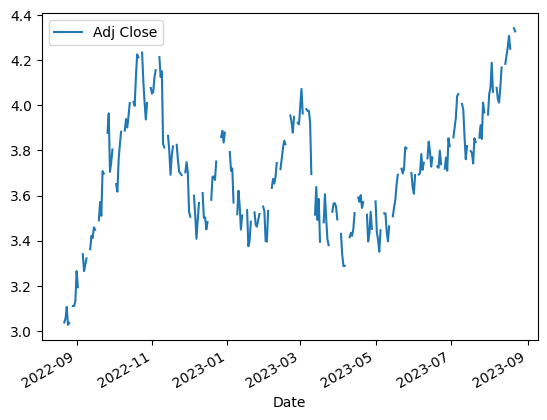

In [ ]:
df.plot(x='Date', y='Adj Close')

# Stocks Earnings
## Nvidia

In [ ]:
url = 'https://finance.yahoo.com/calendar/earnings?symbol=nvda'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36'}

r = requests.get(url, headers=headers)
print(r)

<Response [200]>


In [ ]:
soup = bs4.BeautifulSoup(r.content)
table = soup.find('table' , class_='W(100%)')
table_headers = table.find_all('th')
row_elements = table.find_all('td')

In [ ]:
headers = [header.text for header in table_headers]
headers

['Symbol',
 'Company',
 'Earnings Date',
 'EPS Estimate',
 'Reported EPS',
 'Surprise(%)']

In [ ]:
elements = [element.text for element in row_elements]
elements_arr = np.array(elements)
table_cols = len(headers)
table_len = int(len(elements_arr)/table_cols)
rows = elements_arr.reshape(table_len, table_cols)
rows[:5]

array([['NVDA', 'NVIDIA Corp', 'May 22, 2024, 6 AMEDT', '-', '-', '-'],
       ['NVDA', 'NVIDIA Corp', 'Feb 21, 2024, 4 PMEST', '-', '-', '-'],
       ['NVDA', 'NVIDIA Corp', 'Nov 15, 2023, 4 PMEST', '-', '-', '-'],
       ['NVDA', 'NVIDIA Corp', 'Aug 23, 2023, 5 PMEDT', '2.09', '-', '-'],
       ['NVDA', 'NVIDIA Corp', 'Aug 23, 2023, 4 PMEDT', '2.09', '-', '-']],
      dtype='<U22')

In [ ]:
earnings = pd.DataFrame(data=rows, columns=headers)
earnings

,Symbol,Company,Earnings Date,EPS Estimate,Reported EPS,Surprise(%)
0,NVDA,NVIDIA Corp,"May 22, 2024, 6 AMEDT",-,-,-
1,NVDA,NVIDIA Corp,"Feb 21, 2024, 4 PMEST",-,-,-
2,NVDA,NVIDIA Corp,"Nov 15, 2023, 4 PMEST",-,-,-
3,NVDA,NVIDIA Corp,"Aug 23, 2023, 5 PMEDT",2.09,-,-
4,NVDA,NVIDIA Corp,"Aug 23, 2023, 4 PMEDT",2.09,-,-
...,...,...,...,...,...,...
95,NVDA,NVIDIA Corporation,"Aug 21, 2000, 12 AMEDT",0.01,0.01,+7.76
96,NVDA,NVIDIA Corporation,"May 16, 2000, 12 AMEDT",0.01,0.01,+19.68
97,NVDA,NVIDIA Corporation,"Feb 15, 2000, 12 AMEST",0.01,0.01,+9.42
98,NVDA,NVIDIA Corporation,"Nov 18, 1999, 12 AMEST",-,0.01,+24.28


In [ ]:
url = 'https://www.forexfactory.com/calendar'

r = requests.get(url)
print(r)

<Response [403]>


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd


#day = input('Enter Day: ')
#month = input('Enter Month: ')
#year = input('Enter Year: ')

day, month, year = ('17', 'aug', '2023')

url = f'https://www.forexfactory.com/calendar?day={month}{day}.{year}'
url = f'https://www.forexfactory.com/calendar'
useragent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36"
headers = {'User-Agent': useragent}

In [ ]:
url

'https://www.forexfactory.com/calendar'

In [ ]:
Total_Data = []

def getdata(link):
    r = requests.get(link, headers=headers).text
    soup = BeautifulSoup( r , 'lxml')
    table = soup.find('table' , class_='calendar__table')
    rows = table.find_all('tr')
    tr = table.select('tr[class*="calendar__row calendar__row"]')
    for i in range(1,len(tr)):

        row = tr[i]
        # Date
        try:
            date = row.find('td' , class_='calendar__cell calendar__date').text.strip()
        except:
            date = ""

        # Event ID


        # Time
        try:
            time = row.find('td' , class_='calendar__cell calendar__time').text.strip()
        except:
            time = ""


        # Currency
        try:
            currency = row.find('td' , class_='calendar__cell calendar__currency').text.strip()
        except:
            currency = ""

        # Impact
        try:
            impact_color = row.find('td' , class_='calendar__cell calendar__impact').find('span')['class'][1].split('-')[-1]
            if impact_color == 'ora':
                impact = 'Medium'
            elif impact_color == 'yel':
                impact = 'Low'
            elif impact_color == 'red':
                impact = 'High'
            elif impact_color == 'gra':
                impact = 'Non-Economic'
        except:
            impact = ''

        # Event
        try:
            event = row.find('span' , class_='calendar__event-title').text.strip()
        except:
            event = ''

        # Actual
        try:
            actual = row.find('td' , class_='calendar__cell calendar__actual').text.strip()
        except:
            actual = " "

        # Forecast
        try:
            forecast = row.find('td' , class_='calendar__cell calendar__forecast').text.strip()
        except:
            forecast = ''

        # Previous
        try:
            previous = row.find('td' , class_='calendar__cell calendar__previous').text.strip()
        except:
            previous = ''

        myData = {
            'Time' : time ,
            'Currency' : currency,
            'Impact' : impact,
            'Event Title' : event,
            'Actual' : actual,
            'Forecast' : forecast,
            'Previous' : previous
        }
        Total_Data.append(myData)



    return

# Call the function
print('Scrapping the Data . . . . . .')
getdata(url)

# Store data to CSV

print('Scrapping Completed . . . . . .')
df = pd.DataFrame(Total_Data)
df.to_csv(f'{day}.{month}.{year}-Forex_Factory.csv' , index=False)

print('Data Stored to a CSV . . . . ')

Scrapping the Data . . . . . .


AttributeError: ignored

In [ ]:
df

,Time,Currency,Impact,Event Title,Actual,Forecast,Previous
0,6:45pm,NZD,Low,Trade Balance,,-50M,9M
1,,CNY,Medium,5-y Loan Prime Rate,,4.05%,4.20%
2,,,,,,,
3,2:00am,EUR,Low,German PPI m/m,,-0.1%,-0.3%
4,Tentative,EUR,Low,German Buba Monthly Report,,,
5,8:30am,CAD,Low,NHPI m/m,,0.0%,0.1%
6,,,,,,,
7,1:00am,JPY,Low,BOJ Core CPI y/y,,2.9%,3.0%
8,,GBP,Low,Public Sector Net Borrowing,,3.4B,17.7B
9,,USD,Medium,Richmond Manufacturing Index,,-8,-9
